In [79]:
import os
from azure.identity import DefaultAzureCredential,get_bearer_token_provider
from langchain_openai import AzureChatOpenAI
from langgraph.graph import MessagesState,StateGraph,START,END
from IPython.display import Image,display
from langchain_core.messages import HumanMessage
from langchain_core.tools import  tool
from langgraph.prebuilt import ToolNode

In [7]:
token_provider= get_bearer_token_provider(DefaultAzureCredential(),"https://cognitiveservices.azure.com/.default")
chatmodel = AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    model= "gpt-4o-mini"
)
aimessage= chatmodel.invoke("hi")
aimessage.content

'Hello! How can I assist you today?'

In [48]:
def call_model(state:MessagesState) -> MessagesState:
    input = state['messages']
    response = chatmodel.invoke(input)
    state['messages']=response
    return state


In [44]:
call_model({"messages":["How are you?"]})

{'messages': AIMessage(content="I'm just a program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 11, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BiC4RmaPduKy6LjBCD7W5GiIOESwV', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'l

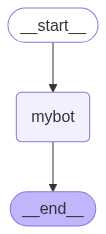

In [49]:
graph= StateGraph(MessagesState)
graph.add_node("mybot",call_model)



graph.add_edge(START,"mybot")
graph.add_edge("mybot",END)
compiledgraph = graph.compile()

display(Image(compiledgraph.get_graph().draw_mermaid_png()))

In [51]:
compiledgraph.invoke({"messages":[HumanMessage(content="How are you?")]})

{'messages': [HumanMessage(content='How are you?', additional_kwargs={}, response_metadata={}, id='a3a9de7a-54d4-4d46-9edc-dbc7254f7734'),
  AIMessage(content="I'm just a program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 11, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BiC5HN3mXnPkm6z3t8JplyGpFAOG2', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexua

In [60]:
## tools

@tool
def gettemperature(query:str) -> str:
    """ This is a custom tool that will help to ge temperature based on given state """
    if "delhi" in query.lower() :
        return "Today is sunny in Delhi with 38 degree"
    return f"Today, it is going to rain in {query}"

@tool
def multiply(a:int, b: int)->int:
    """This will mutiply and return the product as response"""
    return a*b

In [55]:
print(gettemperature.args)
print(gettemperature.description)
print(gettemperature.name)

{'query': {'title': 'Query', 'type': 'string'}}
This is a custom tool that will help to ge temperature based on given state
gettemperature


In [80]:
tools =[gettemperature,multiply]
tools
ToolNode(tools)

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'gettemperature': StructuredTool(name='gettemperature', description='This is a custom tool that will help to ge temperature based on given state', args_schema=<class 'langchain_core.utils.pydantic.gettemperature'>, func=<function gettemperature at 0x00000269C7790680>), 'multiply': StructuredTool(name='multiply', description='This will mutiply and return the product as response', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000269C7790400>)}, tool_to_state_args={'gettemperature': {}, 'multiply': {}}, tool_to_store_arg={'gettemperature': None, 'multiply': None}, handle_tool_errors=True, messages_key='messages')

In [64]:
## Tool Binding
llm_with_tools = chatmodel.bind_tools([gettemperature,multiply])
response= llm_with_tools.invoke("Multiply 3 with 4")
response.tool_calls


[{'name': 'multiply',
  'args': {'a': 3, 'b': 4},
  'id': 'call_pPyuBhuWEFjCQxupS8vEdcYs',
  'type': 'tool_call'}]

In [65]:
def call_model(state : MessagesState) ->MessagesState:
    input = state["messages"]
    response = llm_with_tools.invoke(input)
    state['messages']=response
    return state

In [68]:
response = call_model({"messages":[HumanMessage(content="Multiply 2 with 3?")]})
response

{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_F78aRYtkb14IDVnD14AFgTol', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 89, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BiCIqpUbAQuaf7kJxSfA0d9DSCVmN', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'

In [69]:
def router_function(state: MessagesState)->MessagesState:
    """ This function will help LLM weather to call LLM or a TOOL"""
    lastmessage = state["messages"][-1]
    if lastmessage.tool_calls:
        return "tools"
    return END

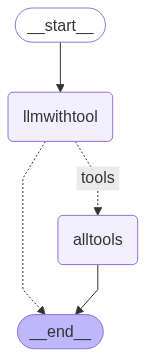

In [82]:
workflow = StateGraph(MessagesState)
workflow.add_node("llmwithtool",call_model)
workflow.add_node("alltools",ToolNode(tools))


workflow.add_edge(START,"llmwithtool")
workflow.add_conditional_edges("llmwithtool",router_function,
                               {
                                   "tools":"alltools",
                                   END:END
                               }
                               )
compiledworkflow = workflow.compile()

display(Image(compiledworkflow.get_graph().draw_mermaid_png()))

In [86]:
response= compiledworkflow.invoke({"messages":[HumanMessage(content="Multiply 2 with 3?")]})
response["messages"][-1].content

'6'

In [87]:
response=  compiledworkflow.invoke({"messages":[HumanMessage(content="What is the weather in Mumbai")]})
response["messages"][-1].content

'Today, it is going to rain in Mumbai'

In [88]:
response=  compiledworkflow.invoke({"messages":[HumanMessage(content="What is the latest news in Azure?")]})
response["messages"][-1].content

"I don't have access to real-time news or updates. However, you can check the official Azure blog or reliable tech news websites for the latest updates on Azure. They often cover new services, features, and announcements related to Azure."